# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # This will let us pull from the page

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/boo#search=1~gallery~0~0'# Boats for sale
raw = requests.get(url,headers=header) # This gets the page info

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [ ]:
from bs4 import BeautifulSoup as soup # This is an HTML parser
bsObj = soup(raw.content,'html.parser') #This then parses the HTML
listings = bsObj.find_all(class_="cl-static-search-result") # This will find all the listings within our given criteria

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [ ]:
import re # This is importing regular expressions

brands = ['wave armor', 'john boat', 'triton', 'rinker', 'coleman', 'sun dolphin', 'alumacraft', 'tidewater', 'carolina',
          'dagger', 'lincoln', 'baja', 'nucanoe', 'old town', 'trophy', 'bass hunter', 'grady white',
           'crestliner', 'mariah'] # Boat brand names

data = [] # This allows us to save our listings within this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # This pulls the brand from the Title string:
    words = title.split()
    hits = [word for word in words if word in brands] # This is finding brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # This pulls years from the title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # This is finding years in the title
    if regex_search is None: # This will record the year as a missing value if not found
        year = np.nan
    else: # This will record the year as a match if it is found
        year = regex_search.group(0)
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})

## 2. Get your search results of interest and extract data from them, using code similar to what's above.


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [ ]:
# This is wrangling our data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_boats.csv') # This is saving the data to a csv
df.head()

(34, 6)


,title,price,year,link,brand,age
0,wave armor drive on pwc and boat ports,2200,NaN,https://charlottesville.craigslist.org/boa/d/g...,missing,NaN
1,john boat 3 trolling motors and battery,800,NaN,https://charlottesville.craigslist.org/boa/d/l...,missing,NaN
2,jon boat and vee bottom boat,200,NaN,https://charlottesville.craigslist.org/boa/d/a...,missing,NaN
3,14ft jon boat crestliner,2850,NaN,https://charlottesville.craigslist.org/boa/d/d...,crestliner,NaN
4,triton tr-175 fishing boat,6500,NaN,https://charlottesville.craigslist.org/boa/d/p...,triton,NaN


With the data in and wrangled, we can now do EDA:

count        34.000000
mean      14844.970588
std       29274.552825
min           0.000000
25%         207.500000
50%        2350.000000
75%       13499.750000
max      134999.000000
Name: price, dtype: float64


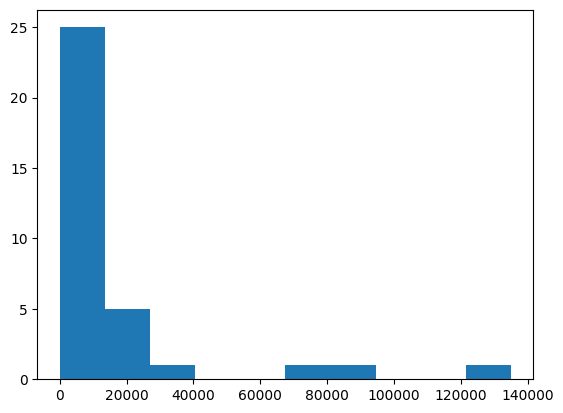

count     7.000000
mean     12.000000
std       5.887841
min       4.000000
25%       7.500000
50%      14.000000
75%      15.000000
max      21.000000
Name: age, dtype: float64


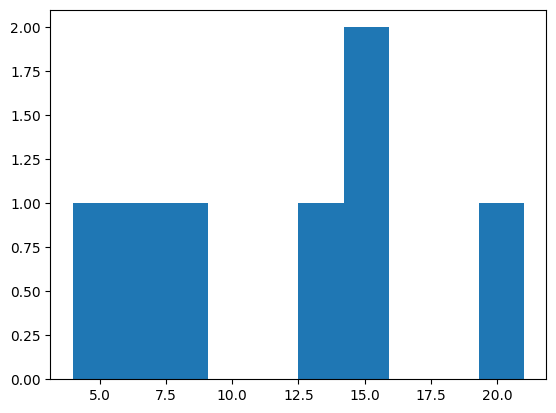

In [ ]:
# This is exploratory a data analysis for age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [ ]:
# This examines the price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
alumacraft   1.0  35000.000000           NaN  35000.0  35000.0  35000.0   
baja         1.0  25000.000000           NaN  25000.0  25000.0  25000.0   
carolina     2.0  15497.000000   4946.919041  11999.0  13748.0  15497.0   
coleman      1.0    135.000000           NaN    135.0    135.0    135.0   
crestliner   2.0   8425.000000   7884.240610   2850.0   5637.5   8425.0   
dagger       1.0    175.000000           NaN    175.0    175.0    175.0   
lincoln      1.0    999.000000           NaN    999.0    999.0    999.0   
mariah       1.0   9500.000000           NaN   9500.0   9500.0   9500.0   
missing     19.0  18777.736842  38015.235826      1.0    190.0    800.0   
nucanoe      1.0   1300.000000           NaN   1300.0   1300.0   1300.0   
rinker       2.0   1250.000000   1767.766953      0.0    625.0   1250.0   
triton       1.0   6500.000000           NaN   6500.0   6500.0   6500.0   
trophy       1.0  18999.000000           NaN  18999.0  18999.0  18999.0   

                               
                75%       max  
brand                          
alumacraft  35000.0   35000.0  
baja        25000.0   25000.0  
carolina    17246.0   18995.0  
coleman       135.0     135.0  
crestliner  11212.5   14000.0  
dagger        175.0     175.0  
lincoln       999.0     999.0  
mariah       9500.0    9500.0  
missing     10250.0  134999.0  
nucanoe      1300.0    1300.0  
rinker       1875.0    2500.0  
triton       6500.0    6500.0  
trophy      18999.0   18999.0

In [ ]:
# This examines the age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                              
           count  mean       std   min   25%   50%   75%   max
brand                                                         
alumacraft   1.0   7.0       NaN   7.0   7.0   7.0   7.0   7.0
baja         0.0   NaN       NaN   NaN   NaN   NaN   NaN   NaN
carolina     1.0  15.0       NaN  15.0  15.0  15.0  15.0  15.0
coleman      0.0   NaN       NaN   NaN   NaN   NaN   NaN   NaN
crestliner   1.0  14.0       NaN  14.0  14.0  14.0  14.0  14.0
dagger       0.0   NaN       NaN   NaN   NaN   NaN   NaN   NaN
lincoln      0.0   NaN       NaN   NaN   NaN   NaN   NaN   NaN
mariah       1.0  21.0       NaN  21.0  21.0  21.0  21.0  21.0
missing      2.0   6.0  2.828427   4.0   5.0   6.0   7.0   8.0
nucanoe      0.0   NaN       NaN   NaN   NaN   NaN   NaN   NaN
rinker       0.0   NaN       NaN   NaN   NaN   NaN   NaN   NaN
triton       0.0   NaN       NaN   NaN   NaN   NaN   NaN   NaN
trophy       1.0  15.0       NaN  15.0  15.0  15.0  15.0  15.0

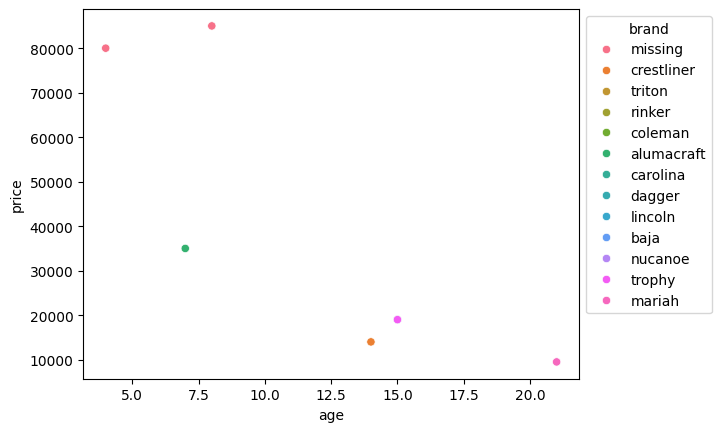

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           log_price   log_age
log_price   6.612781 -0.438288
log_age    -0.438288  0.331166
           log_price   log_age
log_price   1.000000 -0.896454
log_age    -0.896454  1.000000


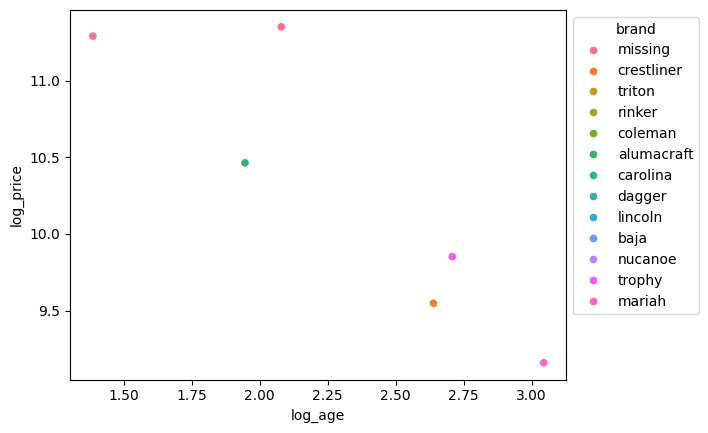

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

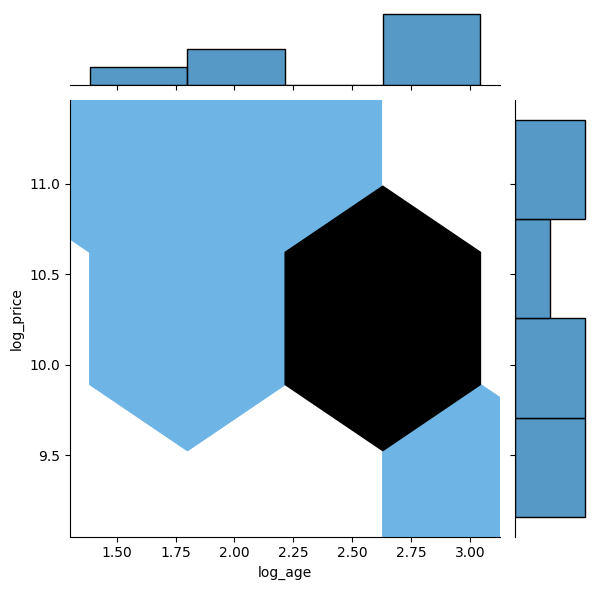

In [ ]:
sns.jointplot(data=df, x='log_age', y='log_price',kind='hex')

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.

The final thing we want to do is go from scraping a single page to crawling around.

The idea here is that every web page is connected to some other page. By extracting links as we move from page to page, we can create a web crawler that wanders around for us, gathering information of interest.

In this case, we want to use the search results to then visit each individual page for each listing. Since we saved the links to the web pages in the previous scrape, we can now simply for-loop over that column in the dataframe, visiting the page listing for each of the cars in the search results:

What are the new features here?

First, we don't want to overwhelm the servers, so we put a small delay between each request of a listing, `time.sleep(random.randint(1, 3))`. This waits a random amount of time between 1 and 3 seconds to avoid overwhelming their server.

Second, we use the try/except block. This is a useful control structure in general, but especially for web scraping. Python tries the statements under `try:`, and if it fails, executes the steps under `except:`. This can happen, in this case, with missing data, which crashes the crawler. Instead, we put our missing codes into our dataframe right away.

Third, we used `.find().find().get_text()` to find the data we're looking for. In general, the structure of mark-up langauges like HTML and XML makes it possible to "drill down" into their entries and extract the information of interest. This exploitation of mark-up languages could be the subject of a whole course on procuring data from the web.

With the data scraped, we can make a new dataframe, combine it with the old one using `pd.concat`, and do some wrangling to clean the data up:

## 4. (Optional) From your search results, crawl to the links and extract more information about every listing in your original dataframe. Wrangle and do some EDA.